Scoring in next 10 actions model - Model Evaluation - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/")

In [20]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from config import chain_file_path
from vaep.domain.contracts.modelling_data_contract import ModellingDataContract
from vaep.domain.modelling.supermodel import SuperXGBClassifier
from vaep.domain.modelling.model_evaluation import XGBClassifierEvaluator
from vaep.domain.preprocessing.preprocessing import *

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


New Model

In [23]:
new_version = 1
model_name = "vaep_scoring"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/vaep/model_outputs/models/"
preproc_file_path = ""
train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/vaep/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(new_version)+".csv"
test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/vaep/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(new_version)+".csv"

Comparison Model

In [5]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/vaep/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/vaep/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [6]:
RESPONSE = ModellingDataContract.RESPONSE_SCORES

Features

In [7]:
# FEATURES = ModellingDataContract.open_goal_modelling_feature_list

Load Data

In [8]:
df_modelling = pd.read_csv(chain_file_path)
df_modelling.tail()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Season
1169201,252,ballUp,turnover,1984.0,4,1937,1942.0,St Kilda,St Kilda,Dan Butler,Dan_Butler,Kick,-65.0,14.0,clanger,NaN,NaN,129,160,St Kilda,North Melbourne,left,202319_StKilda_NorthMelbourne,202319,NaN,2023.0
1169202,252,ballUp,turnover,1985.0,4,1937,1945.0,St Kilda,St Kilda,Dan Butler,Dan_Butler,Out On Full After Kick,-69.0,34.0,NaN,NaN,NaN,129,160,St Kilda,North Melbourne,left,202319_StKilda_NorthMelbourne,202319,NaN,2023.0
1169203,253,possGain,behind,1986.0,4,1949,1949.0,North Melbourne,North Melbourne,Luke Davies-Uniacke,Luke_Davies-Uniacke,OOF Kick In,67.0,-34.0,NaN,NaN,NaN,129,160,St Kilda,North Melbourne,left,202319_StKilda_NorthMelbourne,202319,NaN,2023.0
1169204,253,possGain,behind,1987.0,4,1949,1976.0,North Melbourne,North Melbourne,Luke Davies-Uniacke,Luke_Davies-Uniacke,Kick,67.0,-34.0,ineffective,True,NaN,129,160,St Kilda,North Melbourne,left,202319_StKilda_NorthMelbourne,202319,NaN,2023.0
1169205,253,possGain,behind,1988.0,4,1949,1978.0,North Melbourne,North Melbourne,Luke Davies-Uniacke,Luke_Davies-Uniacke,Behind,67.0,-34.0,NaN,NaN,missLeft,129,160,St Kilda,North Melbourne,left,202319_StKilda_NorthMelbourne,202319,NaN,2023.0


Processing

In [10]:
schema_chains = convert_chains_to_schema(df_modelling)

In [13]:
df_modelling.shape, schema_chains.shape

((1169206, 26), (947887, 12))

In [14]:
X = create_gamestate_features(schema_chains)
X.head()

,action_type,type_Kick,type_Handball,type_Carry,type_Uncontested Mark,type_Contested Mark,type_Loose Ball Get,type_Hard Ball Get,type_Spoil,type_Gather,type_Free For,type_Knock On,type_Shot,type_Tackle,type_Error,outcome_type,outcome_effective,outcome_ineffective,outcome_clanger,type_Kick_outcome_effective,type_Kick_outcome_ineffective,type_Kick_outcome_clanger,type_Handball_outcome_effective,type_Handball_outcome_ineffective,type_Handball_outcome_clanger,type_Carry_outcome_effective,type_Carry_outcome_ineffective,type_Carry_outcome_clanger,type_Uncontested Mark_outcome_effective,type_Uncontested Mark_outcome_ineffective,type_Uncontested Mark_outcome_clanger,type_Contested Mark_outcome_effective,type_Contested Mark_outcome_ineffective,type_Contested Mark_outcome_clanger,type_Loose Ball Get_outcome_effective,type_Loose Ball Get_outcome_ineffective,type_Loose Ball Get_outcome_clanger,type_Hard Ball Get_outcome_effective,type_Hard Ball Get_outcome_ineffective,type_Hard Ball Get_outcome_clanger,type_Spoil_outcome_effective,type_Spoil_outcome_ineffective,type_Spoil_outcome_clanger,type_Gather_outcome_effective,type_Gather_outcome_ineffective,type_Gather_outcome_clanger,type_Free For_outcome_effective,type_Free For_outcome_ineffective,type_Free For_outcome_clanger,type_Knock On_outcome_effective,type_Knock On_outcome_ineffective,type_Knock On_outcome_clanger,type_Shot_outcome_effective,type_Shot_outcome_ineffective,type_Shot_outcome_clanger,type_Tackle_outcome_effective,type_Tackle_outcome_ineffective,type_Tackle_outcome_clanger,type_Error_outcome_effective,type_Error_outcome_ineffective,type_Error_outcome_clanger,quarter,quarter_seconds,overall_seconds,start_x,start_y,end_x,end_y,dx,dy,movement,action_type,type_Kick,type_Handball,type_Carry,type_Uncontested Mark,type_Contested Mark,type_Loose Ball Get,type_Hard Ball Get,type_Spoil,type_Gather,type_Free For,type_Knock On,type_Shot,type_Tackle,type_Error,outcome_type,outcome_effective,outcome_ineffective,outcome_clanger,type_Kick_outcome_effective,type_Kick_outcome_ineffective,type_Kick_outcome_clanger,type_Handball_outcome_effective,type_Handball_outcome_ineffective,type_Handball_outcome_clanger,type_Carry_outcome_effective,type_Carry_outcome_ineffective,type_Carry_outcome_clanger,type_Uncontested Mark_outcome_effective,type_Uncontested Mark_outcome_ineffective,type_Uncontested Mark_outcome_clanger,type_Contested Mark_outcome_effective,type_Contested Mark_outcome_ineffective,type_Contested Mark_outcome_clanger,type_Loose Ball Get_outcome_effective,type_Loose Ball Get_outcome_ineffective,type_Loose Ball Get_outcome_clanger,type_Hard Ball Get_outcome_effective,type_Hard Ball Get_outcome_ineffective,type_Hard Ball Get_outcome_clanger,type_Spoil_outcome_effective,type_Spoil_outcome_ineffective,type_Spoil_outcome_clanger,type_Gather_outcome_effective,type_Gather_outcome_ineffective,type_Gather_outcome_clanger,type_Free For_outcome_effective,type_Free For_outcome_ineffective,type_Free For_outcome_clanger,type_Knock On_outcome_effective,type_Knock On_outcome_ineffective,type_Knock On_outcome_clanger,type_Shot_outcome_effective,type_Shot_outcome_ineffective,type_Shot_outcome_clanger,type_Tackle_outcome_effective,type_Tackle_outcome_ineffective,type_Tackle_outcome_clanger,type_Error_outcome_effective,type_Error_outcome_ineffective,type_Error_outcome_clanger,quarter,quarter_seconds,overall_seconds,start_x,start_y,end_x,end_y,dx,dy,movement,action_type,type_Kick,type_Handball,type_Carry,type_Uncontested Mark,type_Contested Mark,type_Loose Ball Get,type_Hard Ball Get,type_Spoil,type_Gather,type_Free For,type_Knock On,type_Shot,type_Tackle,type_Error,outcome_type,outcome_effective,outcome_ineffective,outcome_clanger,type_Kick_outcome_effective,type_Kick_outcome_ineffective,type_Kick_outcome_clanger,type_Handball_outcome_effective,type_Handball_outcome_ineffective,type_Handball_outcome_clanger,type_Carry_outcome_effective,type_Carry_outcome_ineffective,type_Carry_outcome_clanger,type_Uncontested 

In [18]:
y = create_gamestate_labels(schema_chains)
y = y[RESPONSE]

In [19]:
schema_chains.shape, X.shape, y.shape

((947887, 12), (947887, 226), (947887,))

Preprocess Data

In [230]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [26]:
categorical_cols = set(list(X)) - set(list(X.select_dtypes('number')) + list(X.select_dtypes('bool')))

In [27]:
X_preproc = X.drop(columns = categorical_cols)

In [37]:
score_feature_names = ModellingDataContract.feature_list_scores
X_preproc.columns = score_feature_names

Load Model

In [39]:
super_xgb = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

In [40]:
super_xgb.xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5247020196937383, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.04887204207320006, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5912211573524633, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=65, missing=nan, monotone_constraints={},
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Get Predictions

In [41]:
X_preproc = X_preproc[super_xgb.xgb_model.get_booster().feature_names]

In [42]:
preds = super_xgb.predict(X_preproc)

In [43]:
probas = super_xgb.predict_proba(X_preproc)[:, 1]

In [44]:
cal_probas = super_xgb.predict_proba(X_preproc, calibrate=True)


Compare Model

In [240]:
# compare_train_data = pd.read_csv(compare_train_predictions_file_path)
# compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [241]:
# compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
#                                                           'xgb_probas':'old_probas'})
# compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
#                                                         'xgb_probas':'old_probas'})

In [242]:
# training_data.shape, compare_train_data.shape

((5897, 79), (6288, 24))

In [243]:
# training_data = pd.merge(training_data, compare_train_data[["Match_ID", "Chain_Number", "Order", 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])
# test_data = pd.merge(test_data, compare_test_data[["Match_ID", "Chain_Number", 'Order', 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])

Evaluate Model

In [79]:
eval_data = pd.concat([schema_chains, X_preproc], axis=1)
eval_data['xgb_preds'] = preds
eval_data['xgb_probas'] = probas
eval_data['xgb_cal_probas'] = cal_probas
# eval_data['scores'] = y*1

xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = eval_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                    #    compare_name='xgb_probas',
                                    #    compare_label_name="xgb_preds"
                                       )

Model Averages

In [60]:
eval_data[['scores', 'xgb_probas', 'xgb_cal_probas']].describe()

,scores,scores,xgb_probas,xgb_cal_probas
count,947887.000000,947887.000000,947887.000000,947887.000000
mean,0.115342,0.115342,0.116428,0.115422
std,0.319434,0.319434,0.142992,0.140470
min,0.000000,0.000000,0.000808,0.001552
25%,0.000000,0.000000,0.038812,0.043152
50%,0.000000,0.000000,0.079754,0.081241
75%,0.000000,0.000000,0.138322,0.133682
max,1.000000,1.000000,0.998053,0.999552


Plots

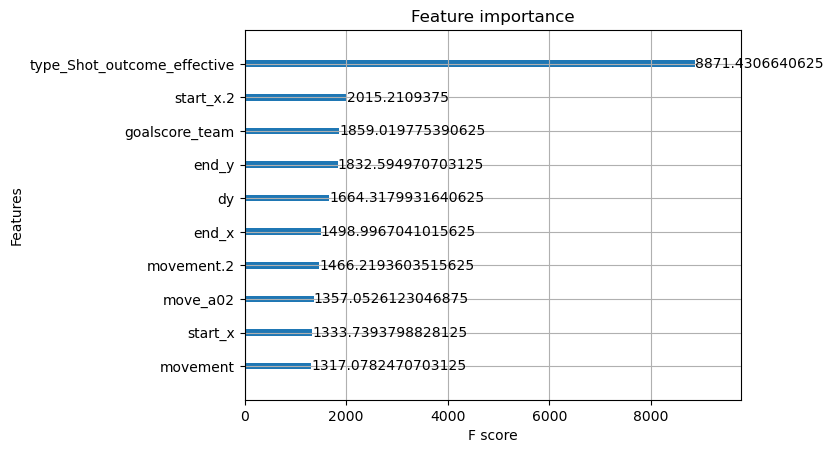

In [61]:
xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

In [62]:
xgb_evals.plot_shap_summary_plot()

ValueError: feature_names must be unique

In [65]:
# top_features = xgb_evals.get_ranked_feature_importance()
# top_10_features = top_features[:10]
# top_10_features

In [66]:
# for col in top_10_features:
#     xgb_evals.plot_pdp([col])

In [64]:
# for col in top_10_features:
#     train_xgb_evals.plot_ice([col])
#     test_xgb_evals.plot_ice([col])

In [67]:
# for col in top_10_features:
#     train_xgb_evals.plot_feature_ave(col)
#     test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [68]:
xgb_evals.get_log_loss()

Expected Log-Loss: 	0.2940


0.29397832697718035

In [81]:
xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.0821


0.08208979416277329

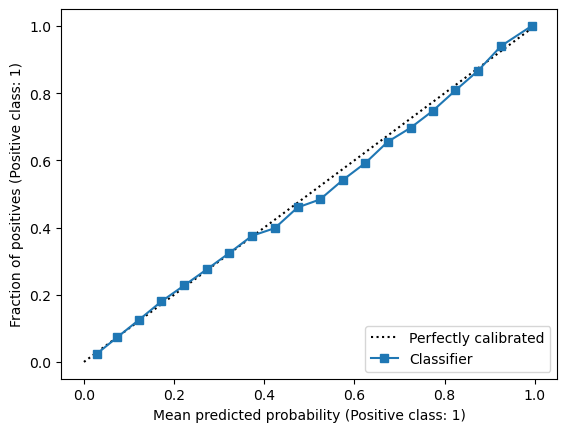

In [82]:
xgb_evals.display_calibration_curve(nbins=20)
